# Handle Financial Data For Machine Learning

In this notebook we explain various ways of handling financial timeseries data. If you have a data science project involving timeseries, this notebook might help you at handling this particular kind of data. Indeed, when it comes to training machine learning models, the data should be handled decently to make the training process easy and fast.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load the data.

The data we load here is provided by us. It is the result of REST API endpoints gathered on the binance exchange platform for the BCT/USDT pair. The prices were recorded every 2s between first of september and end of november. We provide OHLCA data from 10 minutes, 30 minutes and 1 hour. Feel free to test this notebook with your own data.

In [2]:
# Dataset parameters.
PATH = "dataset"
SYMBOL = "btcusdt"
DATASET = "ohlc"
PERIOD = 600

# Set the filename name for the training and test dataset. 
FILENAME_TR = "binance_{}_{}_period_{}_{}.csv".format(SYMBOL, DATASET, PERIOD, "train")
FILENAME_TE = "binance_{}_{}_period_{}_{}.csv".format(SYMBOL, DATASET, PERIOD, "test")

We define a fucntion to convert the csv dataset into pandas DataFrames.

In [3]:
def load(path, filename):
    """Load the filename as pandas DataFrame.
    """
    df = pd.read_csv(path + "/" + filename)
    df = df.set_index("time")
    df.index = pd.to_datetime(df.index)
    return df

In [4]:
df_tr = load(PATH, FILENAME_TR)
df_te = load(PATH, FILENAME_TE)

We can now visualise the data. 

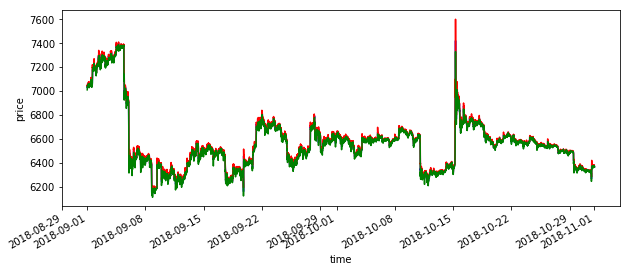

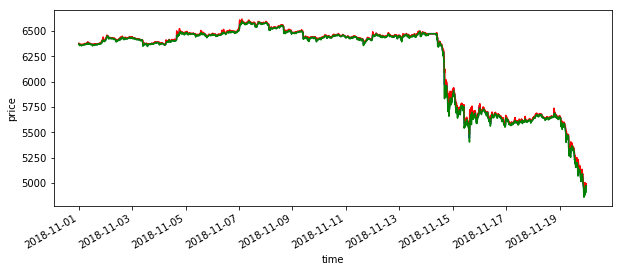

In [5]:
# Display the training dataset.
plt.figure(figsize=(10,4))
plt.plot(df_tr.index.values, df_tr["avg"].values, color="b")
plt.plot(df_tr.index.values, df_tr["high"].values, color="r")
plt.plot(df_tr.index.values, df_tr["low"].values, color="g")
plt.xlabel("time")
plt.ylabel("price")
plt.gcf().autofmt_xdate()
plt.show()

# Display the test dataset.
plt.figure(figsize=(10,4))
plt.plot(df_te.index.values, df_te["avg"].values, color="b")
plt.plot(df_te.index.values, df_te["high"].values, color="r")
plt.plot(df_te.index.values, df_te["low"].values, color="g")
plt.xlabel("time")
plt.ylabel("price")
plt.gcf().autofmt_xdate()
plt.show()

## 2. Normalisation methods.

We have a dataset $X \in \mathbb{R}^{T \times n}$ where $T$ is the length of the timeseries we loaded. In order to train a machine learning algorithm, we have to draw samples from the given data. So we have to extract as many samples as possible from the given dataset, i.e. timeseries with a shorter length that we will call $lk$. In order the build a dataset,

$$
X = [ X_1, X_2, ..., X_m]
$$

where $m \in \mathbb{N}$ and $X_i \in \mathbb{R}^{N \times n}$ 

Once this step has been performed, we will have to normalise the timeseries.

### A. Windowing.

We provide here a function that performes the timeseries's windowing over a specified look back horizon. 

In [6]:
def window(df, lookback):
    """Window the timeseries df.
    
    :param df: the timeseries.
    :type df: pandas dataframe.
    :param lookback: the lookback horizon.
    :type lookback: int.
    """
    data = []
    for k in range(lookback):
        s = lookback - k - 1        
        dfs = df.shift(s)
        data.append(dfs)
    return pd.concat(data, axis=1)

### B. Mean and standard deviation method.

In [7]:
def normalise_std(df, lookback, mean=None, std=None):
    """Normalise the timeseries df with the pivot method.
    
    :param df: the timeseries.
    :type df: pandas dataframe.
    :param lookback: the lookback horizon.
    :type lookback: int.
    """
    eps = 1.0E-8
    data = []
    
    if mean is None:
        mean = df.mean()
    if std is None:
        std =df.std()
    
    for k in range(lookback):
        s = lookback - k - 1
        dfs = ( df.shift(s) - mean ) / ( std + eps )
        data.append(dfs)
        
    return pd.concat(data, axis=1)

### C. Pivot method.

For a timeseries given as

$$
x = [x_1, x_2, ..., x_N]
$$

where,

$$ N \in \mathbb{N}$$

The pivot method normalisation method is computed as follows

$$ 
z_{t} = 100 ( \frac{x_{t}}{x_{0}} - 1 ) 
\; \text{where} \;
t \in  [1, N]
$$


In [8]:
def normalise_pvt(df, lookback, log=False):
    """Normalise the timeseries df with the pivot method.
    
    :param df: the timeseries.
    :type df: pandas dataframe.
    :param lookback: the lookback horizon.
    :type lookback: int.
    """
    eps = 1.0E-8
    data = []
    for k in range(lookback):
        s = lookback - k - 1
        if log is False:
            dfs = 100 * ( df.shift(s) / ( df[["avg"]] + eps ) - 1.0 )
        else:
            dfs = 100 * ( np.log(df.shift(s)) - np.log(df) )
        data.append(dfs)
    return pd.concat(data, axis=1)

### D. Percentage change method

For a timeseries given as

$$
x = [x_1, x_2, ..., x_N]
$$

where,

$$ N \in \mathbb{N}$$

The percentage change normalisation method is computed as follows,

$$ 
z_{t} = 100 ( \frac{x_{t}}{x_{t-1}} - 1 ) 
\; \text{where} \;
t \in  [1, N]
$$



In [9]:
def normalise_pct(df, lookback, log=False):
    """Normalise the timeseries df with the pct method.
    
    :param df: the timeseries.
    :type df: pandas dataframe.
    :param lookback: the lookback horizon.
    :type lookback: int.
    """
    eps = 1.0E-8
    data = []
    for k in range(lookback):
        s = lookback -k - 1
        if log is False:
            dfs = 100 * ( df.shift(s) / ( df.shift(s+1) + eps ) - 1.0 )
        else:
            dfs = 100 * ( np.log( df.shift(s) / ( df.shift(s+1) + eps)))
        data.append(dfs)
    return pd.concat(data, axis=1)

## 3. Visualisation

We can now visualise the result of the normalisation method.

In [35]:
# Set the look back parameter.
LK = 16

In [15]:
def plot_corr(df):
    arr = df.corr()
    plt.figure()
    imgplot = plt.imshow(arr)
    imgplot.set_cmap("jet")
    plt.colorbar()
    plt.show()

/Users/mdhoffschmidt/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mdhoffschmidt/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


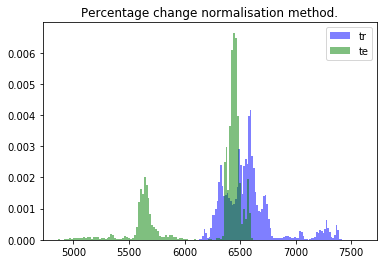

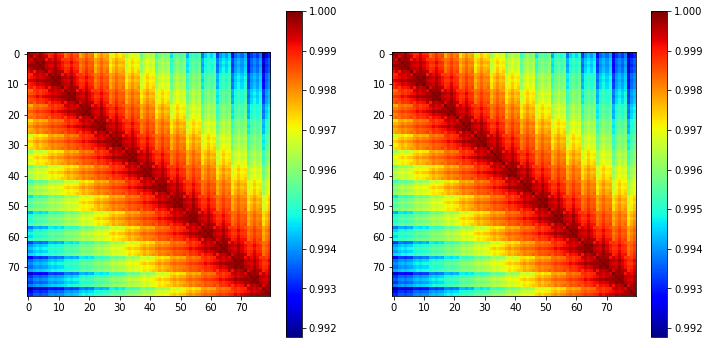

In [36]:
# Window.
df_tr_w = window(df_tr, LK)
df_te_w = window(df_te, LK)

# Histogram.
plt.figure()
plt.hist(df_tr_w.values.reshape(-1,1), 100, density=True, facecolor="b", alpha=0.50, label="tr");
plt.hist(df_te_w.values.reshape(-1,1), 100, density=True, facecolor="g", alpha=0.50, label="te");
plt.title("Percentage change normalisation method.")
plt.legend()
plt.show()

# Heat map.
plt.figure(figsize=(12,6))
plt.subplot(121)
img = plt.imshow(df_te_w.corr())
img.set_cmap("jet")
plt.colorbar()
plt.subplot(122)
img = plt.imshow(df_te_w.corr())
img.set_cmap("jet")
plt.colorbar()
plt.show()

### A. Visualise mean and std method.

The following visualisation shows why the mean and std method is not suited for timeseries data. 

In [ ]:
# Compute the percetange change normalised timeseries.
data_std_tr = normalise_std(df_tr, LK).values.reshape(len(df_tr), LK, -1)
data_std_te = normalise_std(df_te, LK, df_tr.mean(), df_tr.std()).values.reshape(len(df_te), LK, -1)

# Histogram.
plt.figure()
hista = plt.hist(data_std_tr.reshape(-1,1), 500, density=True, facecolor="b", alpha=0.50, label="tr")
hista = plt.hist(data_std_te.reshape(-1,1), 500, density=True, facecolor="g", alpha=0.50, label="te")
plt.xlim([-1, 1])
plt.title("Percentage change normalisation method.")
plt.legend()
plt.show()

In [ ]:
data_std_tr = normalise_std(df_tr, LK)
plot_corr(data_std_tr)

### B. Visualise percentage change method.

In [ ]:
# Compute the percetange change normalised timeseries.
data_pvt_tr = normalise_pvt(df_tr, LK).values.reshape(len(df_tr), LK, -1)
data_pvt_te = normalise_pvt(df_te, LK).values.reshape(len(df_te), LK, -1)

# Histogram.
plt.figure()
hista = plt.hist(data_pvt_tr.reshape(-1,1), 100, density=True, facecolor="b", alpha=0.50)
hista = plt.hist(data_pvt_te.reshape(-1,1), 100, density=True, facecolor="g", alpha=0.50)
plt.xlim([99, 101])
plt.title("Percentage change normalisation method.")
plt.show()

### C. Visualise percentage change method.

In [ ]:
# Compute the percetange change normalised timeseries.
data_pct_tr = normalise_pct(df_tr, LK).values.reshape(len(df_tr), LK, -1)
data_pct_te = normalise_pct(df_te, LK).values.reshape(len(df_te), LK, -1)

# Histogram.
plt.figure()
hista = plt.hist(data_pct_tr.reshape(-1,1), 500, density=True, facecolor="b", alpha=0.50)
hista = plt.hist(data_pct_te.reshape(-1,1), 500, density=True, facecolor="g", alpha=0.50)
plt.xlim([-1, 1])
plt.title("Percentage change normalisation method.")
plt.show()

In [ ]:
df_tr_pct = normalise_pvt(df_tr, 16)

print(df_tr.shape)
print(df_tr_pct.shape)
    
plot_corr(df_tr_pct)